In [1]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
import unicodedata
import spacy
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('punkt')
import random
import os
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances,plot_slice

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natedrake7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/natedrake7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Pre-Processing

In [47]:
#Read csv files
train_set = pd.read_csv('./Data/train_set.csv')
valid_set = pd.read_csv('./Data/valid_set.csv')
test_set = pd.read_csv('./Data/test_set.csv')



#Drop Party and New ID columns since we dont need them
labels_to_drop = ['Party','New_ID']
train_set = train_set.drop(columns=labels_to_drop)
valid_set = valid_set.drop(columns=labels_to_drop)
test_set = test_set.drop(columns=['Party'])

#Make all text lowercase
train_set['Text'] = train_set['Text'].str.lower()
valid_set['Text'] = valid_set['Text'].str.lower()
test_set['Text'] = test_set['Text'].str.lower()

train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'#', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'#', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'#', '', x))

#Remove accents from all text
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

train_set['Text'] = train_set['Text'].apply(remove_accents)
valid_set['Text'] = valid_set['Text'].apply(remove_accents)
test_set['Text'] = test_set['Text'].apply(remove_accents)

#Remove stopwords and replace them with a single space
stop = stopwords.words('greek')
pat = r'\b(?:{})\b'.format('|'.join(stop))

train_set['Text'] = train_set['Text'].str.replace(pat,'',regex=True)
valid_set['Text'] = valid_set['Text'].str.replace(pat,'',regex=True)
test_set['Text'] = test_set['Text'].str.replace(pat,'',regex=True)

#Remove multiple white spaces and replace them with a single space
train_set['Text'] = train_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
valid_set['Text'] = valid_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
test_set['Text'] = test_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces

#Remove links and replace them with a single space
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links

#Replace non greek words with single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))

#Find retweets and replace them withn single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))

#Load lemmatizer
nlp = spacy.load("el_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

#Lemmatize text to replace words with their dictionary value
train_set['Text'] = train_set['Text'].apply(lemmatize_text)
valid_set['Text'] = valid_set['Text'].apply(lemmatize_text)
test_set['Text'] = test_set['Text'].apply(lemmatize_text)

Save Pre-Processed Data

In [48]:
train_set.to_csv('processed_df',index=False)
valid_set.to_csv('processed_valid',index=False)
test_set.to_csv('processed_test',index=False)

Load Pre-Processed Data

In [2]:
train_set = pd.read_csv('processed_df')

test_set = pd.read_csv('processed_test')

valid_set = pd.read_csv('processed_valid')

WordCloud

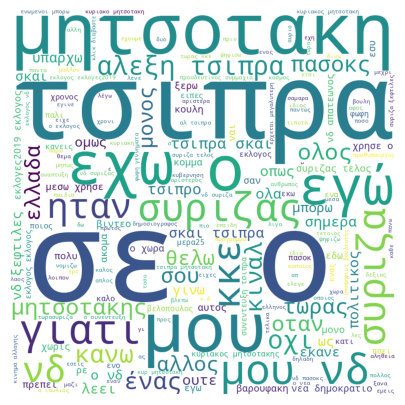

In [132]:
wordcloud = WordCloud(width=800, height=800,background_color='white').generate(' '.join(train_set['Text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Token Frequency

In [140]:
tokens = ' '.join(train_set['Text']).split()
token_counts = Counter(tokens)
print(token_counts.most_common(10))

[('ο', 18181), ('τσιπρα', 9889), ('μου', 8189), ('νδ', 8168), ('μητσοτακη', 6883), ('σε', 4528), ('εκλογος', 4298), ('εχω', 4207), ('συριζα', 3949), ('συριζας', 3630)]


Text Length Distribution

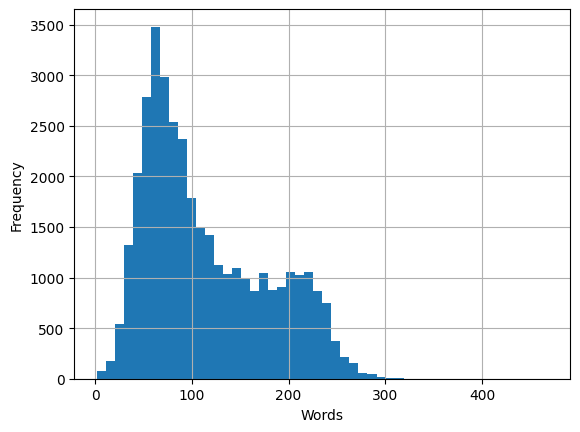

In [137]:
df = train_set.copy()

df['Text'] = df['Text'].apply(len)
df['Text'].hist(bins=50)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

Tokenize Text and create W2V Model

In [3]:
#Tokenize text so word2vec can utilize it
train_set['Tokenized_Text'] = train_set['Text'].apply(lambda x: word_tokenize(x))

#Create Word2Vec models
model = Word2Vec(sentences=train_set['Tokenized_Text'], vector_size=300,window=5,min_count=2,negative = 10)

#Train the model
model.train(train_set['Tokenized_Text'], total_examples= len(train_set['Text']), epochs=30)

#Save the model
model.save("./Data/word2vec_new.model")

Load self-trained Word2Vec Model

In [3]:
word2vec_model = Word2Vec.load('./Data/word2vec_new.model')

Tokenize Texts

In [4]:
#Tokenize all texts
valid_set['Tokenized_Text'] = valid_set['Text'].apply(lambda x: word_tokenize(x))
test_set['Tokenized_Text'] = test_set['Text'].apply(lambda x: word_tokenize(x))
train_set['Tokenized_Text'] = train_set['Text'].apply(lambda x: word_tokenize(x))

In [6]:
print(word2vec_model.wv.most_similar('μητσοτακης'))

[('Μητσοτακης', 0.5248427987098694), ('προχωρησει', 0.34290000796318054), ('μεγαλοεπιχειρηματιος', 0.34258195757865906), ('μητσοτακη', 0.32073691487312317), ('συρρικνωσει', 0.3201495110988617), ('φορων', 0.3172350823879242), ('λεπτομερεια', 0.3168053925037384), ('λουτσεσκος', 0.3160354197025299), ('μεταρρυθμιστος', 0.3137797713279724), ('επιχειρησιακων', 0.31251680850982666)]


Encode Labels

In [5]:
encoder  = LabelEncoder() #initialize label encoder so we can set integer values to the label unique values

X_train_labels = encoder.fit_transform(train_set['Sentiment']) #Transform the labels
X_valid_labels = encoder.fit_transform(valid_set['Sentiment']) #For both training and validation

print(encoder.classes_)
print(encoder.transform(encoder.classes_))
labels = {0 : 'NEGATIVE',1 : 'NEUTRAL',2 : 'POSITIVE'}

['NEGATIVE' 'NEUTRAL' 'POSITIVE']
[0 1 2]


Create Dictionary

In [6]:
dictionary = word2vec_model.wv.key_to_index
print(dictionary)

{'ο': 0, 'τσιπρα': 1, 'μου': 2, 'νδ': 3, 'μητσοτακη': 4, 'σε': 5, 'εκλογος': 6, 'εχω': 7, 'συριζα': 8, 'συριζας': 9, 'κκε': 10, '2019': 11, 'σκαι': 12, 'εγώ': 13, 'μητσοτακης': 14, 'ένας': 15, 'κιναλ': 16, 'γιατι': 17, 'εκλογες2019': 18, 'κανω': 19, 'αλεξη': 20, 'ηταν': 21, 'νεα': 22, 'πασοκς': 23, 'μπορω': 24, 'συνεντευξη': 25, 'ελλαδα': 26, 'οχι': 27, 'σου': 28, 'τωρας': 29, 'ολος': 30, 'τσιπρο': 31, 'κυβερνηση': 32, '1': 33, '2': 34, 'τελος': 35, 'γεννηματα': 36, 'θελω': 37, 'πολιτικος': 38, 'χωρα': 39, 'οταν': 40, 'λεει': 41, 'αλλος': 42, 'ολα': 43, 'μονος': 44, 'ουτε': 45, 'ρε': 46, '7': 47, 'ξεφτιλες': 48, 'κυριακος': 49, 'σημερα': 50, 'οπως': 51, 'ερχεται': 52, 'πολυ': 53, '5': 54, 'μεσω': 55, 'φωφη': 56, 'υπαρχω': 57, '4': 58, 'πιο': 59, 'εγω': 60, 'ως': 61, 'κουλη': 62, '3': 63, 'βαρουφακη': 64, 'ψηφος': 65, 'υποψηφιος': 66, 'εδω': 67, 'κυριακη': 68, 'ειπες': 69, 'πρεπει': 70, 'α': 71, 'βουλη': 72, 'ενο': 73, 'πασοκ': 74, 'γινω': 75, 'κομμα': 76, 'ψηφιζω': 77, 'ενα': 78, 'δημο

Create Embedding Matrix

In [7]:
embedding_matrix = np.zeros((len(dictionary), 300))

for word,i in dictionary.items():#Place the w2v vector to the i-th place on the embedding table,creating an embedding matrix
    embedding_matrix[i] = word2vec_model.wv[word] #where each word's vector is in the corresponding index as in the dictionary above

Convert Tweets to Vectors

In [8]:
def ConvertTextToIndices(text):
    indices = []
    for sentence in text:
        sentence_indices = []
        for word in sentence:
            if word in dictionary:
                sentence_indices.append(dictionary[word])
        indices.append(sentence_indices)
    return indices

#Convert the sentences to a sequence of keys,where each key represents the place of the correspoding vector(of the word we are replacing)
wordvec_train_indices = ConvertTextToIndices(train_set['Tokenized_Text']) #in the embedding matrix
wordvec_valid_indices = ConvertTextToIndices(valid_set['Tokenized_Text'])
wordvec_test_indices = ConvertTextToIndices(test_set['Tokenized_Text'])



Check Shape

In [11]:
len(wordvec_train_indices)

36630

Find the maximun length of a sentence in all 3 Datasets

In [9]:
max_length = 0

for i,row in enumerate(wordvec_train_indices):
    train_row_length = len(row)
    if i < len(wordvec_test_indices):
        test_row_length = len(wordvec_test_indices[i])
    if i < len(wordvec_valid_indices):
        valid_row_length = len(wordvec_valid_indices[i])
    # Update max_length if the current row's length is greater
    if train_row_length > max_length:
        max_length = train_row_length
    if test_row_length > max_length:
        max_length = test_row_length
    if valid_row_length > max_length:
        max_length = valid_row_length

print(max_length)

58


Convert List To Tensors

In [10]:
#convert the list of indexes to tensors,so dataloader can utilize them and Cuda can be used
wordvec_train_indices = [torch.LongTensor(seq) for seq in wordvec_train_indices]
wordvec_valid_indices = [torch.LongTensor(seq) for seq in wordvec_valid_indices]
wordvec_test_indices = [torch.LongTensor(seq) for seq in wordvec_test_indices]

Configure Max length for each List of indices

In [11]:
#set the length of the first value in all the lists to max_length,and then all the rest will be shaped according to that.
wordvec_train_indices[0] = nn.ConstantPad1d((0, max_length - wordvec_train_indices[0].shape[0]), 0)(wordvec_train_indices[0])
wordvec_valid_indices[0] = nn.ConstantPad1d((0, max_length - wordvec_valid_indices[0].shape[0]), 0)(wordvec_valid_indices[0])
wordvec_test_indices[0] = nn.ConstantPad1d((0, max_length - wordvec_test_indices[0].shape[0]), 0)(wordvec_test_indices[0])


Create Tensorflow tensors

In [121]:
batch_size = 128
#Train set
X_train_tensor = pad_sequence(wordvec_train_indices, batch_first=True, padding_value=0)
Labels_train_tensor = torch.tensor(X_train_labels,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_train_tensor,Labels_train_tensor) #Create a dataset
Train_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the train set


#Val set
X_val_tensor = pad_sequence(wordvec_valid_indices, batch_first=True, padding_value=0)
Labels_val_tensor = torch.tensor(X_valid_labels,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_val_tensor,Labels_val_tensor) #Create a dataset
Validation_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the validation set


X_test_tensor = pad_sequence(wordvec_test_indices, batch_first=True, padding_value=0)
Dataset = TensorDataset(X_test_tensor) #Create a dataset
Test_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the test set

Set Gpu Or Cpu

In [14]:
if torch.cuda.is_available(): #if nvidia gpu is available
   device="cuda" #set devide to cuda since GPUs are much faster at deep learning
else: 
   device="cpu" #else set CPU
print("Device =",device)

Device = cuda


Recurrent Neural Network

In [31]:
class RNN(nn.Module):
    def __init__(self, cell_type, hidden_size, output_size, embedding_matrix, num_layers=1, num_hidden_layers=1, dropout_prob=0.0):
        super(RNN, self).__init__()

        cells = {
            "RNN" : nn.RNN,
            "LSTM" : nn.LSTM,
            "GRU" : nn.GRU
        }

        self.cell_type = cell_type
        #use pretrained embedding matrix created above
        self.embedding_matrix = embedding_matrix
        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)

        #list to hold the hidden layers
        self.hidden_layers = nn.ModuleList()

        self.hidden_layers_number = num_hidden_layers
        # Add the specified number of hidden layers
        for _ in range(num_hidden_layers):
            hidden_layer = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(hidden_layer)

        #Initialize RNN cells correctly
        self.rnn = cells[cell_type](
            input_size=self.embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob if cell_type != 'LSTM' and num_layers > 1 else 0.0  # Apply dropout only for RNN and GRU
        )

        #Last layer is a linear layer which takes an input of the hidden size and returns an output size vector(our case 3).
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        embedded = self.embedding(x)  #Get the sequence from the embedding matrix

        if self.cell_type != 'LSTM': #if cell is GRU of RNN
            r_out, _ = self.rnn(embedded)
        else: #else cell is LSTM
            r_out, (_, _) = self.rnn(embedded)


        for hidden_layer in self.hidden_layers: #use hidden layers
            r_out = hidden_layer(r_out)

        # Output from the last time step
        out = self.out(r_out[:, -1, :])
        return out


Optimization using Optuna

In [53]:
def objective(trial):
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64, 128])
    output_size = 3
    cell_type = trial.suggest_categorical('cell_type', ['LSTM', 'GRU'])

    # Determine the number of stacked RNNs
    num_layers = trial.suggest_int('num_layers', 1, 3)

    # Determine the number of hidden layers
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)


    # Determine if gradient clipping is optimal
    gradient_clipping = trial.suggest_categorical('gradient_clipping', [True, False])

    # Determine dropout
    dropout_prob = trial.suggest_uniform('dropout_prob', 0.0, 0.5)

    # Create Neural Network
    net = RNN(cell_type, hidden_size, output_size, embedding_matrix,
              num_layers=num_layers, num_hidden_layers=num_hidden_layers,dropout_prob=dropout_prob).to(device)

    #Suggested epochs by the lab were 1,epoch testing was done after the use of the optuna framework
    #Same applies for Learning Rate
    EPOCH = 1
    LR = 0.001

    optimizer = torch.optim.Adam(net.parameters(), lr=LR)
    loss_func = nn.CrossEntropyLoss()

    net.train()
    step_count = 0

    for epoch in range(EPOCH):
        torch.cuda.synchronize()
        losses = []
        for step, (x, y) in enumerate(Train_set):
            optimizer.zero_grad()

            x, y = x.to(device), y.to(device)

            output = net(x)

            loss = loss_func(output, y)
            losses.append(loss.item())

            step_count += 1

            loss.backward()
            # Apply gradient clipping if enabled
            if gradient_clipping:
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

            optimizer.step()
        #Compute average loss since validation occurs every epoch
        avg_loss = sum(losses) / len(losses)

        with torch.no_grad():
            validation_steps = 0
            accuracy = 0

            for test_x, test_y in Validation_set:

                test_x, test_y = test_x.to(device), test_y.to(device)

                net.eval()

                test_output = net(test_x)
                pred_y = torch.argmax(test_output, dim=1).squeeze()

                accuracy += (pred_y == test_y).sum().item() / float(batch_size)
                validation_steps += 1
            #Find the average accuracy for the whole dateset
            accuracy /= validation_steps
            print('Epoch: ', epoch, '| train loss: %.4f' % avg_loss, '| test accuracy: %.2f' % accuracy)
            #print statistics
        net.train()
    return accuracy

#Create a study and optimize our objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=200)



[I 2024-02-11 13:33:09,299] A new study created in memory with name: no-name-537061e6-b2df-46c4-86df-cd79aa835358
/tmp/ipykernel_4317/344936682.py:17: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-02-11 13:33:11,132] Trial 0 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 64, 'cell_type': 'LSTM', 'num_layers': 3, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.10214890721015141}. Best is trial 0 with value: 0.3323170731707317.


Epoch:  0 | train loss: 1.0991 | test accuracy: 0.33


[I 2024-02-11 13:33:12,721] Trial 1 finished with value: 0.3873856707317073 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.3775966719015389}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0988 | test accuracy: 0.39


[I 2024-02-11 13:33:14,125] Trial 2 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 32, 'cell_type': 'LSTM', 'num_layers': 3, 'num_hidden_layers': 1, 'gradient_clipping': False, 'dropout_prob': 0.21340569678966376}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0989 | test accuracy: 0.33


[I 2024-02-11 13:33:15,587] Trial 3 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 128, 'cell_type': 'LSTM', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.38034116728348577}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0993 | test accuracy: 0.33


[I 2024-02-11 13:33:17,428] Trial 4 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 3, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.4445908678772044}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0999 | test accuracy: 0.33


[I 2024-02-11 13:33:18,690] Trial 5 finished with value: 0.3790015243902439 and parameters: {'hidden_size': 32, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.08910964206906963}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0988 | test accuracy: 0.38


[I 2024-02-11 13:33:19,856] Trial 6 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 32, 'cell_type': 'LSTM', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.027984358961891165}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0995 | test accuracy: 0.33


[I 2024-02-11 13:33:21,347] Trial 7 finished with value: 0.3466082317073171 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.05591163149876477}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0981 | test accuracy: 0.35


[I 2024-02-11 13:33:23,066] Trial 8 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 128, 'cell_type': 'LSTM', 'num_layers': 2, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.36628267521571956}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0992 | test accuracy: 0.33


[I 2024-02-11 13:33:24,637] Trial 9 finished with value: 0.3700457317073171 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 3, 'num_hidden_layers': 3, 'gradient_clipping': True, 'dropout_prob': 0.18573620588528833}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0984 | test accuracy: 0.37


[I 2024-02-11 13:33:26,016] Trial 10 finished with value: 0.3673780487804878 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.30149204813906894}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0982 | test accuracy: 0.37


[I 2024-02-11 13:33:27,274] Trial 11 finished with value: 0.38376524390243905 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.4746108285001994}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0993 | test accuracy: 0.38


[I 2024-02-11 13:33:28,632] Trial 12 finished with value: 0.37328506097560976 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.4833737765996611}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0983 | test accuracy: 0.37


[I 2024-02-11 13:33:30,244] Trial 13 finished with value: 0.36070884146341464 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.40080243953683564}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0980 | test accuracy: 0.36


[I 2024-02-11 13:33:31,779] Trial 14 finished with value: 0.34222560975609756 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.49978152540630044}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0987 | test accuracy: 0.34


[I 2024-02-11 13:33:33,312] Trial 15 finished with value: 0.3487042682926829 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.31158010866309793}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0988 | test accuracy: 0.35


[I 2024-02-11 13:33:34,875] Trial 16 finished with value: 0.36852134146341464 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': True, 'dropout_prob': 0.3021343848544691}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0980 | test accuracy: 0.37


[I 2024-02-11 13:33:36,567] Trial 17 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.41619346974304694}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.1000 | test accuracy: 0.33


[I 2024-02-11 13:33:37,953] Trial 18 finished with value: 0.3643292682926829 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.34550722914048965}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0983 | test accuracy: 0.36


[I 2024-02-11 13:33:39,579] Trial 19 finished with value: 0.35022865853658536 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.44928319409788564}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0987 | test accuracy: 0.35


[I 2024-02-11 13:33:41,333] Trial 20 finished with value: 0.3628048780487805 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 3, 'gradient_clipping': True, 'dropout_prob': 0.2527049905866719}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0990 | test accuracy: 0.36


[I 2024-02-11 13:33:42,632] Trial 21 finished with value: 0.3389862804878049 and parameters: {'hidden_size': 32, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.13677616359734868}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.1001 | test accuracy: 0.34


[I 2024-02-11 13:33:43,947] Trial 22 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 32, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.00029123890706655997}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.1009 | test accuracy: 0.33


[I 2024-02-11 13:33:45,243] Trial 23 finished with value: 0.3671875 and parameters: {'hidden_size': 32, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.11573649541694986}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0976 | test accuracy: 0.37


[I 2024-02-11 13:33:46,558] Trial 24 finished with value: 0.36871189024390244 and parameters: {'hidden_size': 32, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.4507801576824625}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0985 | test accuracy: 0.37


[I 2024-02-11 13:33:47,889] Trial 25 finished with value: 0.3618521341463415 and parameters: {'hidden_size': 32, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.2537105380543416}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0991 | test accuracy: 0.36


[I 2024-02-11 13:33:49,741] Trial 26 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 128, 'cell_type': 'LSTM', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.15949374026717555}. Best is trial 1 with value: 0.3873856707317073.


Epoch:  0 | train loss: 1.0992 | test accuracy: 0.33


[I 2024-02-11 13:33:51,060] Trial 27 finished with value: 0.3875762195121951 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.07420283175899405}. Best is trial 27 with value: 0.3875762195121951.


Epoch:  0 | train loss: 1.0979 | test accuracy: 0.39


[I 2024-02-11 13:33:52,529] Trial 28 finished with value: 0.3723323170731707 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.4252639703880451}. Best is trial 27 with value: 0.3875762195121951.


Epoch:  0 | train loss: 1.0976 | test accuracy: 0.37


[I 2024-02-11 13:33:54,020] Trial 29 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 64, 'cell_type': 'LSTM', 'num_layers': 3, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.3439644940248999}. Best is trial 27 with value: 0.3875762195121951.


Epoch:  0 | train loss: 1.0991 | test accuracy: 0.33


[I 2024-02-11 13:33:55,611] Trial 30 finished with value: 0.3696646341463415 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 3, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.4791866597848534}. Best is trial 27 with value: 0.3875762195121951.


Epoch:  0 | train loss: 1.1001 | test accuracy: 0.37


[I 2024-02-11 13:33:56,915] Trial 31 finished with value: 0.3870045731707317 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.07764498080181383}. Best is trial 27 with value: 0.3875762195121951.


Epoch:  0 | train loss: 1.0985 | test accuracy: 0.39


[I 2024-02-11 13:33:58,197] Trial 32 finished with value: 0.36909298780487804 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.06834914376020935}. Best is trial 27 with value: 0.3875762195121951.


Epoch:  0 | train loss: 1.0993 | test accuracy: 0.37


[I 2024-02-11 13:33:59,461] Trial 33 finished with value: 0.3635670731707317 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.18436296139510278}. Best is trial 27 with value: 0.3875762195121951.


Epoch:  0 | train loss: 1.0982 | test accuracy: 0.36


[I 2024-02-11 13:34:00,708] Trial 34 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 64, 'cell_type': 'LSTM', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': False, 'dropout_prob': 0.04261860015809765}. Best is trial 27 with value: 0.3875762195121951.


Epoch:  0 | train loss: 1.0996 | test accuracy: 0.33


[I 2024-02-11 13:34:02,064] Trial 35 finished with value: 0.37271341463414637 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.08124843348851424}. Best is trial 27 with value: 0.3875762195121951.


Epoch:  0 | train loss: 1.0990 | test accuracy: 0.37


[I 2024-02-11 13:34:03,308] Trial 36 finished with value: 0.3873856707317073 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.22273967601016292}. Best is trial 27 with value: 0.3875762195121951.


Epoch:  0 | train loss: 1.0964 | test accuracy: 0.39


[I 2024-02-11 13:34:04,583] Trial 37 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 64, 'cell_type': 'LSTM', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.22782128248039812}. Best is trial 27 with value: 0.3875762195121951.


Epoch:  0 | train loss: 1.0992 | test accuracy: 0.33


[I 2024-02-11 13:34:06,092] Trial 38 finished with value: 0.3631859756097561 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 3, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.12063421689684892}. Best is trial 27 with value: 0.3875762195121951.


Epoch:  0 | train loss: 1.0994 | test accuracy: 0.36


[I 2024-02-11 13:34:07,394] Trial 39 finished with value: 0.39214939024390244 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.15846224538577353}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0969 | test accuracy: 0.39


[I 2024-02-11 13:34:09,060] Trial 40 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 128, 'cell_type': 'LSTM', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.2171197686594422}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0995 | test accuracy: 0.33


[I 2024-02-11 13:34:10,276] Trial 41 finished with value: 0.38452743902439024 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.16270128049116564}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0971 | test accuracy: 0.38


[I 2024-02-11 13:34:11,454] Trial 42 finished with value: 0.3780487804878049 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.0194976652331836}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0969 | test accuracy: 0.38


[I 2024-02-11 13:34:12,622] Trial 43 finished with value: 0.3679496951219512 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.10605552951229678}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0980 | test accuracy: 0.37


[I 2024-02-11 13:34:13,767] Trial 44 finished with value: 0.3790015243902439 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.15121968162388094}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0977 | test accuracy: 0.38


[I 2024-02-11 13:34:14,887] Trial 45 finished with value: 0.38090701219512196 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.1992881965965888}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0979 | test accuracy: 0.38


[I 2024-02-11 13:34:16,176] Trial 46 finished with value: 0.3875762195121951 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.26724918555305227}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0980 | test accuracy: 0.39


[I 2024-02-11 13:34:17,550] Trial 47 finished with value: 0.3879573170731707 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.27472061149903143}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0976 | test accuracy: 0.39


[I 2024-02-11 13:34:19,166] Trial 48 finished with value: 0.3355564024390244 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.2720480832099217}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0977 | test accuracy: 0.34


[I 2024-02-11 13:34:20,806] Trial 49 finished with value: 0.37671493902439024 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.2867562778305865}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0982 | test accuracy: 0.38


[I 2024-02-11 13:34:22,392] Trial 50 finished with value: 0.3786204268292683 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.390701177956588}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0963 | test accuracy: 0.38


[I 2024-02-11 13:34:23,926] Trial 51 finished with value: 0.37404725609756095 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.23228686062236228}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0964 | test accuracy: 0.37


[I 2024-02-11 13:34:25,239] Trial 52 finished with value: 0.35708841463414637 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.33300137170327676}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0960 | test accuracy: 0.36


[I 2024-02-11 13:34:26,657] Trial 53 finished with value: 0.3711890243902439 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.2648447090245864}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0985 | test accuracy: 0.37


[I 2024-02-11 13:34:28,133] Trial 54 finished with value: 0.3856707317073171 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.3708569844590628}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0962 | test accuracy: 0.39


[I 2024-02-11 13:34:29,550] Trial 55 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.1924432550839934}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0996 | test accuracy: 0.33


[I 2024-02-11 13:34:31,053] Trial 56 finished with value: 0.3647103658536585 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.3150627750459298}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0964 | test accuracy: 0.36


[I 2024-02-11 13:34:32,432] Trial 57 finished with value: 0.3854801829268293 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.23845500734312797}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0982 | test accuracy: 0.39


[I 2024-02-11 13:34:33,821] Trial 58 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 64, 'cell_type': 'LSTM', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.2860572233390069}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0993 | test accuracy: 0.33


[I 2024-02-11 13:34:35,388] Trial 59 finished with value: 0.3544207317073171 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.1325908040110693}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0977 | test accuracy: 0.35


[I 2024-02-11 13:34:36,600] Trial 60 finished with value: 0.3633765243902439 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.2107635914828579}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0995 | test accuracy: 0.36


[I 2024-02-11 13:34:37,979] Trial 61 finished with value: 0.37671493902439024 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.09138248739236529}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0963 | test accuracy: 0.38


[I 2024-02-11 13:34:39,438] Trial 62 finished with value: 0.3666158536585366 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.066667603422731}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0966 | test accuracy: 0.37


[I 2024-02-11 13:34:40,886] Trial 63 finished with value: 0.3852896341463415 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.17841751442367088}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0972 | test accuracy: 0.39


[I 2024-02-11 13:34:42,333] Trial 64 finished with value: 0.35041920731707316 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.049845570291814925}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0981 | test accuracy: 0.35


[I 2024-02-11 13:34:43,788] Trial 65 finished with value: 0.35708841463414637 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': True, 'dropout_prob': 0.32340057984310433}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0995 | test accuracy: 0.36


[I 2024-02-11 13:34:45,101] Trial 66 finished with value: 0.3601371951219512 and parameters: {'hidden_size': 32, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.022366317367192523}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0984 | test accuracy: 0.36


[I 2024-02-11 13:34:46,589] Trial 67 finished with value: 0.3601371951219512 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 3, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.3596207766869677}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0977 | test accuracy: 0.36


[I 2024-02-11 13:34:47,955] Trial 68 finished with value: 0.36108993902439024 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.09288464716729508}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0984 | test accuracy: 0.36


[I 2024-02-11 13:34:49,341] Trial 69 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 64, 'cell_type': 'LSTM', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.17213331732850973}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0991 | test accuracy: 0.33


[I 2024-02-11 13:34:50,850] Trial 70 finished with value: 0.37328506097560976 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.14682653237500032}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0980 | test accuracy: 0.37


[I 2024-02-11 13:34:52,165] Trial 71 finished with value: 0.359375 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.37197841909658746}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0981 | test accuracy: 0.36


[I 2024-02-11 13:34:53,500] Trial 72 finished with value: 0.38071646341463417 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.4150038148712408}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0978 | test accuracy: 0.38


[I 2024-02-11 13:34:54,784] Trial 73 finished with value: 0.3629954268292683 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.29526222478830877}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0974 | test accuracy: 0.36


[I 2024-02-11 13:34:56,062] Trial 74 finished with value: 0.3748094512195122 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.35669302861555446}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0983 | test accuracy: 0.37


[I 2024-02-11 13:34:57,425] Trial 75 finished with value: 0.35060975609756095 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.2669994962543942}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0973 | test accuracy: 0.35


[I 2024-02-11 13:34:58,613] Trial 76 finished with value: 0.36833079268292684 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': False, 'dropout_prob': 0.2467212804452384}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0986 | test accuracy: 0.37


[I 2024-02-11 13:35:00,071] Trial 77 finished with value: 0.3620426829268293 and parameters: {'hidden_size': 32, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.3827724761763278}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0972 | test accuracy: 0.36


[I 2024-02-11 13:35:01,619] Trial 78 finished with value: 0.35270579268292684 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 3, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.20986002717112984}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0994 | test accuracy: 0.35


[I 2024-02-11 13:35:03,072] Trial 79 finished with value: 0.38109756097560976 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.07187078513205777}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0989 | test accuracy: 0.38


[I 2024-02-11 13:35:04,380] Trial 80 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 64, 'cell_type': 'LSTM', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.11933924623649184}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0993 | test accuracy: 0.33


[I 2024-02-11 13:35:05,735] Trial 81 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.2475395330682292}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0991 | test accuracy: 0.33


[I 2024-02-11 13:35:07,064] Trial 82 finished with value: 0.34946646341463417 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.22587174962876957}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0995 | test accuracy: 0.35


[I 2024-02-11 13:35:08,394] Trial 83 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.43524059881458427}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0996 | test accuracy: 0.33


[I 2024-02-11 13:35:09,741] Trial 84 finished with value: 0.3645198170731707 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.23866980946667388}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0980 | test accuracy: 0.36


[I 2024-02-11 13:35:11,082] Trial 85 finished with value: 0.3629954268292683 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.27707460768728975}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0978 | test accuracy: 0.36


[I 2024-02-11 13:35:12,498] Trial 86 finished with value: 0.36051829268292684 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.40601531904850496}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0982 | test accuracy: 0.36


[I 2024-02-11 13:35:14,055] Trial 87 finished with value: 0.37633384146341464 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': True, 'dropout_prob': 0.10504599491495809}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0965 | test accuracy: 0.38


[I 2024-02-11 13:35:15,218] Trial 88 finished with value: 0.3711890243902439 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': False, 'dropout_prob': 0.03999529296255602}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0990 | test accuracy: 0.37


[I 2024-02-11 13:35:16,587] Trial 89 finished with value: 0.3746189024390244 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.25931691795939343}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0976 | test accuracy: 0.37


[I 2024-02-11 13:35:17,955] Trial 90 finished with value: 0.3723323170731707 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 2, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.3057659768054568}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0990 | test accuracy: 0.37


[I 2024-02-11 13:35:19,415] Trial 91 finished with value: 0.3870045731707317 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.17453306305305083}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0972 | test accuracy: 0.39


[I 2024-02-11 13:35:20,738] Trial 92 finished with value: 0.3719512195121951 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.19122610207706356}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0984 | test accuracy: 0.37


[I 2024-02-11 13:35:22,141] Trial 93 finished with value: 0.36032774390243905 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.20154662759360237}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0986 | test accuracy: 0.36


[I 2024-02-11 13:35:23,456] Trial 94 finished with value: 0.38147865853658536 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.16455654550551507}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0966 | test accuracy: 0.38


[I 2024-02-11 13:35:24,912] Trial 95 finished with value: 0.37328506097560976 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.13313762184508782}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0975 | test accuracy: 0.37


[I 2024-02-11 13:35:26,440] Trial 96 finished with value: 0.3774771341463415 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': True, 'dropout_prob': 0.24083445929268102}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0972 | test accuracy: 0.38


[I 2024-02-11 13:35:27,630] Trial 97 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 32, 'cell_type': 'LSTM', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': False, 'dropout_prob': 0.45864260146857994}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0994 | test accuracy: 0.33


[I 2024-02-11 13:35:29,112] Trial 98 finished with value: 0.3856707317073171 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.00804099439677719}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0961 | test accuracy: 0.39


[I 2024-02-11 13:35:30,672] Trial 99 finished with value: 0.375 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': True, 'dropout_prob': 0.012476976696863842}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0965 | test accuracy: 0.38


[I 2024-02-11 13:35:32,100] Trial 100 finished with value: 0.3706173780487805 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.21994045026728004}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0992 | test accuracy: 0.37


[I 2024-02-11 13:35:33,553] Trial 101 finished with value: 0.3911966463414634 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.03985706776571181}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0964 | test accuracy: 0.39


[I 2024-02-11 13:35:35,062] Trial 102 finished with value: 0.36928353658536583 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.0007076956412239016}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0965 | test accuracy: 0.37


[I 2024-02-11 13:35:36,690] Trial 103 finished with value: 0.3704268292682927 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.03260518096901989}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0989 | test accuracy: 0.37


[I 2024-02-11 13:35:38,194] Trial 104 finished with value: 0.3744283536585366 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.05585723152946577}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0972 | test accuracy: 0.37


[I 2024-02-11 13:35:39,660] Trial 105 finished with value: 0.3784298780487805 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.0815214209229835}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0970 | test accuracy: 0.38


[I 2024-02-11 13:35:41,149] Trial 106 finished with value: 0.3717606707317073 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.04637656620821637}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0978 | test accuracy: 0.37


[I 2024-02-11 13:35:42,806] Trial 107 finished with value: 0.3866234756097561 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.335462703113076}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0969 | test accuracy: 0.39


[I 2024-02-11 13:35:44,324] Trial 108 finished with value: 0.3820503048780488 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.3444889854469}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0963 | test accuracy: 0.38


[I 2024-02-11 13:35:46,005] Trial 109 finished with value: 0.3784298780487805 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.3263788337942445}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0984 | test accuracy: 0.38


[I 2024-02-11 13:35:47,378] Trial 110 finished with value: 0.3717606707317073 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': True, 'dropout_prob': 0.40067846444602523}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0981 | test accuracy: 0.37


[I 2024-02-11 13:35:48,726] Trial 111 finished with value: 0.3868140243902439 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.37134767179924977}. Best is trial 39 with value: 0.39214939024390244.


Epoch:  0 | train loss: 1.0977 | test accuracy: 0.39


[I 2024-02-11 13:35:50,106] Trial 112 finished with value: 0.3932926829268293 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.37129429315832113}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0969 | test accuracy: 0.39


[I 2024-02-11 13:35:51,490] Trial 113 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.3833562978689349}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0967 | test accuracy: 0.33


[I 2024-02-11 13:35:52,860] Trial 114 finished with value: 0.3784298780487805 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.33547560689142353}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0966 | test accuracy: 0.38


[I 2024-02-11 13:35:54,243] Trial 115 finished with value: 0.3717606707317073 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.34984564247767824}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0958 | test accuracy: 0.37


[I 2024-02-11 13:35:55,860] Trial 116 finished with value: 0.3866234756097561 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.39512120782397425}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0964 | test accuracy: 0.39


[I 2024-02-11 13:35:57,415] Trial 117 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 64, 'cell_type': 'LSTM', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.3661698090216594}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0995 | test accuracy: 0.33


[I 2024-02-11 13:35:58,929] Trial 118 finished with value: 0.3706173780487805 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.2833928983454637}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0984 | test accuracy: 0.37


[I 2024-02-11 13:36:00,616] Trial 119 finished with value: 0.3776676829268293 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.2949282373777579}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0979 | test accuracy: 0.38


[I 2024-02-11 13:36:02,066] Trial 120 finished with value: 0.36833079268292684 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.14850626722522858}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0987 | test accuracy: 0.37


[I 2024-02-11 13:36:03,649] Trial 121 finished with value: 0.3679496951219512 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.38752326385717295}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0969 | test accuracy: 0.37


[I 2024-02-11 13:36:05,278] Trial 122 finished with value: 0.37728658536585363 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.39734706212488036}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0957 | test accuracy: 0.38


[I 2024-02-11 13:36:06,910] Trial 123 finished with value: 0.3830030487804878 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.4139214186204484}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0979 | test accuracy: 0.38


[I 2024-02-11 13:36:08,399] Trial 124 finished with value: 0.3803353658536585 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.3655754737164274}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0965 | test accuracy: 0.38


[I 2024-02-11 13:36:09,853] Trial 125 finished with value: 0.3790015243902439 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.060468155646045844}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0965 | test accuracy: 0.38


[I 2024-02-11 13:36:11,297] Trial 126 finished with value: 0.36814024390243905 and parameters: {'hidden_size': 32, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': True, 'dropout_prob': 0.42252387170750827}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0974 | test accuracy: 0.37


[I 2024-02-11 13:36:12,925] Trial 127 finished with value: 0.37328506097560976 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 3, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.37413659598360766}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0983 | test accuracy: 0.37


[I 2024-02-11 13:36:14,402] Trial 128 finished with value: 0.39157774390243905 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.07984569952404875}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0977 | test accuracy: 0.39


[I 2024-02-11 13:36:15,777] Trial 129 finished with value: 0.3822408536585366 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.09433903868126416}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0960 | test accuracy: 0.38


[I 2024-02-11 13:36:17,274] Trial 130 finished with value: 0.35766006097560976 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.07217833132592989}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0979 | test accuracy: 0.36


[I 2024-02-11 13:36:18,768] Trial 131 finished with value: 0.38929115853658536 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.08061384559892365}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0963 | test accuracy: 0.39


[I 2024-02-11 13:36:20,202] Trial 132 finished with value: 0.3790015243902439 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.08031722698613396}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0982 | test accuracy: 0.38


[I 2024-02-11 13:36:21,695] Trial 133 finished with value: 0.3860518292682927 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.10428047367193698}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0970 | test accuracy: 0.39


[I 2024-02-11 13:36:23,138] Trial 134 finished with value: 0.38490853658536583 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.037043397514382556}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0982 | test accuracy: 0.38


[I 2024-02-11 13:36:24,556] Trial 135 finished with value: 0.37347560975609756 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.11861664115333673}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0980 | test accuracy: 0.37


[I 2024-02-11 13:36:26,078] Trial 136 finished with value: 0.3549923780487805 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.06039594611752297}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0970 | test accuracy: 0.35


[I 2024-02-11 13:36:27,546] Trial 137 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 64, 'cell_type': 'LSTM', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.02784677873486545}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0993 | test accuracy: 0.33


[I 2024-02-11 13:36:28,938] Trial 138 finished with value: 0.3620426829268293 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': True, 'dropout_prob': 0.3168531631918817}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0976 | test accuracy: 0.36


[I 2024-02-11 13:36:30,235] Trial 139 finished with value: 0.37728658536585363 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.07566923832542635}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0972 | test accuracy: 0.38


[I 2024-02-11 13:36:31,718] Trial 140 finished with value: 0.3833841463414634 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.2590019606940859}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0963 | test accuracy: 0.38


[I 2024-02-11 13:36:33,174] Trial 141 finished with value: 0.3757621951219512 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.09182658252391748}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0986 | test accuracy: 0.38


[I 2024-02-11 13:36:34,538] Trial 142 finished with value: 0.37290396341463417 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.39462659544351275}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0980 | test accuracy: 0.37


[I 2024-02-11 13:36:35,887] Trial 143 finished with value: 0.3702362804878049 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.35854926763683764}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0994 | test accuracy: 0.37


[I 2024-02-11 13:36:37,309] Trial 144 finished with value: 0.3871951219512195 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.10957468831844197}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0969 | test accuracy: 0.39


[I 2024-02-11 13:36:38,743] Trial 145 finished with value: 0.3793826219512195 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': True, 'dropout_prob': 0.11323038284414048}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0951 | test accuracy: 0.38


[I 2024-02-11 13:36:40,063] Trial 146 finished with value: 0.37690548780487804 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': True, 'dropout_prob': 0.05350672190058568}. Best is trial 112 with value: 0.3932926829268293.


Epoch:  0 | train loss: 1.0974 | test accuracy: 0.38


[I 2024-02-11 13:36:41,344] Trial 147 finished with value: 0.3936737804878049 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.18147273139396114}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0966 | test accuracy: 0.39


[I 2024-02-11 13:36:42,526] Trial 148 finished with value: 0.36890243902439024 and parameters: {'hidden_size': 32, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': False, 'dropout_prob': 0.17402952531966503}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0997 | test accuracy: 0.37


[I 2024-02-11 13:36:43,746] Trial 149 finished with value: 0.3321265243902439 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.15765392027350103}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0994 | test accuracy: 0.33


[I 2024-02-11 13:36:44,936] Trial 150 finished with value: 0.3826219512195122 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.20477179460260214}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0974 | test accuracy: 0.38


[I 2024-02-11 13:36:46,283] Trial 151 finished with value: 0.3631859756097561 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.17888306382806138}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0967 | test accuracy: 0.36


[I 2024-02-11 13:36:47,801] Trial 152 finished with value: 0.3898628048780488 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.188470149106031}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0969 | test accuracy: 0.39


[I 2024-02-11 13:36:49,197] Trial 153 finished with value: 0.37652439024390244 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.4989002902308704}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0980 | test accuracy: 0.38


[I 2024-02-11 13:36:50,635] Trial 154 finished with value: 0.38833841463414637 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.19202071900795256}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0970 | test accuracy: 0.39


[I 2024-02-11 13:36:52,096] Trial 155 finished with value: 0.37595274390243905 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.18881287267941502}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0967 | test accuracy: 0.38


[I 2024-02-11 13:36:53,634] Trial 156 finished with value: 0.3751905487804878 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.16728907238196397}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0980 | test accuracy: 0.38


[I 2024-02-11 13:36:55,102] Trial 157 finished with value: 0.3900533536585366 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.19547741413290792}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0958 | test accuracy: 0.39


[I 2024-02-11 13:36:56,642] Trial 158 finished with value: 0.3567073170731707 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.19735831264366224}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0982 | test accuracy: 0.36


[I 2024-02-11 13:36:58,145] Trial 159 finished with value: 0.3677591463414634 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 3, 'gradient_clipping': False, 'dropout_prob': 0.21627197615738825}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.1000 | test accuracy: 0.37


[I 2024-02-11 13:36:59,491] Trial 160 finished with value: 0.3323170731707317 and parameters: {'hidden_size': 128, 'cell_type': 'LSTM', 'num_layers': 1, 'num_hidden_layers': 1, 'gradient_clipping': False, 'dropout_prob': 0.22877089114726054}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0996 | test accuracy: 0.33


[I 2024-02-11 13:37:00,866] Trial 161 finished with value: 0.3828125 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.20382798704362529}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0968 | test accuracy: 0.38


[I 2024-02-11 13:37:02,192] Trial 162 finished with value: 0.3774771341463415 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.18505209368455933}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0976 | test accuracy: 0.38


[I 2024-02-11 13:37:03,512] Trial 163 finished with value: 0.3824314024390244 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.1387620154916963}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0978 | test accuracy: 0.38


[I 2024-02-11 13:37:04,784] Trial 164 finished with value: 0.38833841463414637 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.15738896651316925}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0962 | test accuracy: 0.39


[I 2024-02-11 13:37:06,130] Trial 165 finished with value: 0.36814024390243905 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.08521556785521349}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0967 | test accuracy: 0.37


[I 2024-02-11 13:37:07,510] Trial 166 finished with value: 0.38509908536585363 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.14159433868086468}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0965 | test accuracy: 0.39


[I 2024-02-11 13:37:08,927] Trial 167 finished with value: 0.3717606707317073 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.15936934206859488}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0972 | test accuracy: 0.37


[I 2024-02-11 13:37:10,259] Trial 168 finished with value: 0.3833841463414634 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.12876551980053996}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0974 | test accuracy: 0.38


[I 2024-02-11 13:37:11,598] Trial 169 finished with value: 0.3744283536585366 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.15086777934164328}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0975 | test accuracy: 0.37


[I 2024-02-11 13:37:12,908] Trial 170 finished with value: 0.3669969512195122 and parameters: {'hidden_size': 16, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.1901527135916499}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0982 | test accuracy: 0.37


[I 2024-02-11 13:37:14,262] Trial 171 finished with value: 0.38090701219512196 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.17589388307505488}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0975 | test accuracy: 0.38


[I 2024-02-11 13:37:15,584] Trial 172 finished with value: 0.37271341463414637 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.18120776646583167}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0974 | test accuracy: 0.37


[I 2024-02-11 13:37:16,801] Trial 173 finished with value: 0.38910060975609756 and parameters: {'hidden_size': 64, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.1659657994879768}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0978 | test accuracy: 0.39


[I 2024-02-11 13:37:18,067] Trial 174 finished with value: 0.38833841463414637 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.16464850097420075}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0979 | test accuracy: 0.39


[I 2024-02-11 13:37:19,867] Trial 175 finished with value: 0.3595655487804878 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 3, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.16463982676786693}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0980 | test accuracy: 0.36


[I 2024-02-11 13:37:21,240] Trial 176 finished with value: 0.36166158536585363 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.1974923196787415}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0985 | test accuracy: 0.36


[I 2024-02-11 13:37:22,556] Trial 177 finished with value: 0.3833841463414634 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.12817449197053973}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0978 | test accuracy: 0.38


[I 2024-02-11 13:37:23,816] Trial 178 finished with value: 0.3898628048780488 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.1593978916277305}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0984 | test accuracy: 0.39


[I 2024-02-11 13:37:25,071] Trial 179 finished with value: 0.3669969512195122 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.1597505725906513}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.1005 | test accuracy: 0.37


[I 2024-02-11 13:37:26,342] Trial 180 finished with value: 0.3877667682926829 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.21177406346613775}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0956 | test accuracy: 0.39


[I 2024-02-11 13:37:27,640] Trial 181 finished with value: 0.37595274390243905 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.21178929152001189}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0974 | test accuracy: 0.38


[I 2024-02-11 13:37:28,905] Trial 182 finished with value: 0.39195884146341464 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.22187549669428266}. Best is trial 147 with value: 0.3936737804878049.


Epoch:  0 | train loss: 1.0959 | test accuracy: 0.39


[I 2024-02-11 13:37:30,211] Trial 183 finished with value: 0.39634146341463417 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.17125906907337562}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0969 | test accuracy: 0.40


[I 2024-02-11 13:37:31,574] Trial 184 finished with value: 0.38147865853658536 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.18516963802795652}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0960 | test accuracy: 0.38


[I 2024-02-11 13:37:32,871] Trial 185 finished with value: 0.36585365853658536 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.15154081470533382}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0973 | test accuracy: 0.37


[I 2024-02-11 13:37:34,336] Trial 186 finished with value: 0.3748094512195122 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.19606599039457703}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0977 | test accuracy: 0.37


[I 2024-02-11 13:37:35,789] Trial 187 finished with value: 0.390625 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.16463567690319547}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0973 | test accuracy: 0.39


[I 2024-02-11 13:37:37,325] Trial 188 finished with value: 0.3803353658536585 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.17165222132497066}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0977 | test accuracy: 0.38


[I 2024-02-11 13:37:38,755] Trial 189 finished with value: 0.39634146341463417 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.1697118540587744}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0981 | test accuracy: 0.40


[I 2024-02-11 13:37:40,313] Trial 190 finished with value: 0.38929115853658536 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.17264497538952503}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0977 | test accuracy: 0.39


[I 2024-02-11 13:37:41,840] Trial 191 finished with value: 0.3871951219512195 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.1689874652196203}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0973 | test accuracy: 0.39


[I 2024-02-11 13:37:43,267] Trial 192 finished with value: 0.38090701219512196 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.1592888748919859}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0966 | test accuracy: 0.38


[I 2024-02-11 13:37:44,823] Trial 193 finished with value: 0.36051829268292684 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.18128176747431587}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0970 | test accuracy: 0.36


[I 2024-02-11 13:37:46,291] Trial 194 finished with value: 0.38452743902439024 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.14653328619653563}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0976 | test accuracy: 0.38


[I 2024-02-11 13:37:47,612] Trial 195 finished with value: 0.38490853658536583 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.16783370625300226}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0975 | test accuracy: 0.38


[I 2024-02-11 13:37:48,974] Trial 196 finished with value: 0.3786204268292683 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.19037418233068606}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0980 | test accuracy: 0.38


[I 2024-02-11 13:37:50,265] Trial 197 finished with value: 0.37633384146341464 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.20831909296243337}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0986 | test accuracy: 0.38


[I 2024-02-11 13:37:51,609] Trial 198 finished with value: 0.3698551829268293 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.17490586520740495}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0972 | test accuracy: 0.37


[I 2024-02-11 13:37:52,878] Trial 199 finished with value: 0.38395579268292684 and parameters: {'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.2222045050727095}. Best is trial 183 with value: 0.39634146341463417.


Epoch:  0 | train loss: 1.0971 | test accuracy: 0.38


Get the best parameters

In [55]:
best_params = study.best_params

print("Best parameters:")
print(best_params)

Best parameters:
{'hidden_size': 128, 'cell_type': 'GRU', 'num_layers': 1, 'num_hidden_layers': 2, 'gradient_clipping': False, 'dropout_prob': 0.17125906907337562}


Create Visualizations from the study

The Optimization history

In [56]:
plot_optimization_history(study)

The importance of each hyperparameter to the Objective Function

In [57]:
plot_param_importances(study)

Slice Plot to show the importance of each hyperparameter's value

In [58]:
plot_slice(study)

Learning Curve Functions

In [64]:
def plot_loss_learning_curve(train_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs,train_losses, label='Training Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

    plt.title('Learning Curve')
    
    plt.show()

def plot_acc_learning_curve(train_f1, val_f1):
    epochs = range(1, len(train_f1) + 1)

    plt.plot(epochs,train_f1, label='Training Accuracy')
    plt.plot(epochs,val_f1, label='Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend()

    plt.title('Learning Curve')
    
    plt.show()

Initialize the model based on the study above

In [125]:
net = RNN(cell_type=best_params['cell_type'], hidden_size=best_params['hidden_size'], output_size=3, embedding_matrix=embedding_matrix,
              num_layers=best_params['num_layers'], num_hidden_layers=best_params['num_hidden_layers'],dropout_prob=best_params['dropout_prob']).to(device)

EPOCH = 1
LR = 0.001

optimizer = torch.optim.Adam(net.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

net.train()
train_losses = []
train_accuracies = []
validation_accuracies = []

best_accuracy = 0

for epoch in range(EPOCH):
    torch.cuda.synchronize()

    step_count = 0
    train_accuracy = 0
    losses = []
    
    for step, (x, y) in enumerate(Train_set):
        optimizer.zero_grad()

        x, y = x.to(device), y.to(device)

        output = net(x)

        loss = loss_func(output, y)
        losses.append(loss.item())

        pred_y = torch.argmax(output, dim=1).squeeze()

        train_accuracy += (pred_y == y).sum().item() / float(batch_size)
        step_count += 1

        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

        optimizer.step()

    avg_loss = sum(losses) / len(losses)
    train_accuracies.append(train_accuracy / step_count)
    train_losses.append(sum(losses) / len(losses))

    with torch.no_grad():
        validation_steps = 0
        accuracy = 0

        for test_x, test_y in Validation_set:

            test_x, test_y = test_x.to(device), test_y.to(device)

            net.eval()

            test_output = net(test_x)
            pred_y = torch.argmax(test_output, dim=1).squeeze()

            accuracy += (pred_y == test_y).sum().item() / float(batch_size)
            validation_steps += 1
        accuracy /= validation_steps
        validation_accuracies.append(accuracy)
        print('Epoch: ', epoch, '| train loss: %.4f' % avg_loss, '| test accuracy: %.2f' % accuracy)
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            best_model = net

    net.train()

Epoch:  0 | train loss: 1.0971 | test accuracy: 0.39


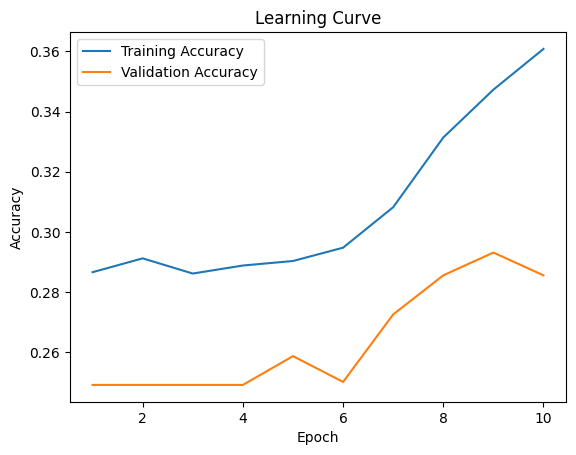

In [119]:
plot_acc_learning_curve(train_accuracies,validation_accuracies)

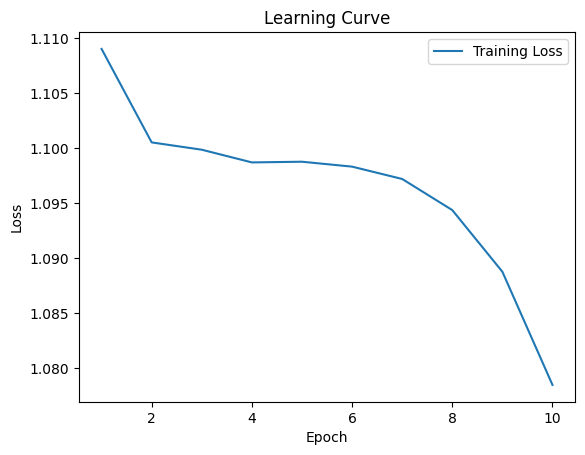

In [120]:
plot_loss_learning_curve(train_losses)

These plots are from the experimenting with the number of epochs and batch sizes,they are not from the final model.Since 1 epoch was used,not learning curve was done

Increasing Epochs seems to do wonders for the training set,yet validation set suffers and overfitting is caused,so 1 epoch is used.

Learning Rate Experiments

$
\begin{array}{|c|c|}
\hline
\text{Learning Rate} & \text{Accuracy}\\
\hline
\text{0.01} & \text{33.3\%}\\
\hline
\text{0.001} & \text{39.0\%}\\
\hline
\text{0.0001} & \text{33.0\%}\\
\hline
\end{array}
$

Best Learning rate is of 1e-3

Batch Size in predictions

$
\begin{array}{|c|c|}
\hline
\text{Batch Size} & \text{Accuracy}\\
\hline
\text{16} & \text{39.0\%}\\
\hline
\text{32} & \text{39.0\%}\\
\hline
\text{64} & \text{39.0\%}\\
\hline
\text{128} & \text{39.0\%}\\
\hline
\text{256} & \text{35.0\%}\\
\hline
\text{512} & \text{33.0\%}\\
\hline
\end{array}
$

Perfect Batch Size seems to be of value 128,since it is faster than lower batch sizes while providing the same accuracy rating.

Batch Size with more epochs

$
\begin{array}{|c|c|c|}
\hline
\text{Batch Size} & \text{Epochs} & \text{Accuracy}\\
\hline
\text{32} & \text{16} & \text{39.0\%}\\
\hline
\text{64} & \text{10} & \text{39.0\%}\\
\hline
\text{128} & \text{10} & \text{39.0\%}\\
\hline
\text{1024} & \text{10} & \text{33.0\%}\\
\hline
\text{6000} & \text{10} & \text{34.0\%}\\
\hline
\text{7000} & \text{10} & \text{29.0\%}\\
\hline
\end{array}
$

Validation accuracy decreases with the increase of epochs.overfitting is massive

In [127]:
Predictions = []

with torch.no_grad(): #disable gradient caclulation since we are testing not training
    for X in Test_set:
        X = X[0].to(device) #Load to GPU

        pred = best_model(X) #predict the label
        Predictions.append(pred.argmax(1).cpu().numpy())

Predictions = np.concatenate(Predictions)

In [130]:
#Create a dataframe based on a dictionary of the IDs and the predictions
y_test = pd.DataFrame(data={'Id': test_set['New_ID'], 'Predicted': Predictions})

#Convert the predicted labels [0,1,2] back to their corresponding labels [NEGATIVE,NEUTRAL,POSITIVE]
y_test['Predicted'] = y_test['Predicted'].apply(lambda x: labels.get(x,x))

#Save as csv
y_test.to_csv('sumbission.csv',index=False)